# Time Series Solar Power Forecasting With Prophet (Creating Input for the Optimization Model)

## Objective and Prerequisites

In this example, we consider a single university building on campus in Melbourne, Australia that has a set of courses scheduled over the course six days (Monday - Saturday). The information used for this example have been adopted from [IEEE's Predict+Optimize Technical Challenge](https://ieee-dataport.org/competitions/ieee-cis-technical-challenge-predictoptimize-renewable-energy-scheduling).
- The building and each courses have a certain energy demand that needs to be satisfied. 
- The buidling's energy demand is assumed to known and each of the courses has a different demand based on the resources required (e.g. class size or a lab). 
- The building has two solar panel installed which are capable of providing energy and there is also the capability of purchasing power directly from the electricity grid to satisfy the demand. 
- The building is equipped with two batteries which can store the energy provided from the solar panels, and can provide this energy when needeed. 

The key learning component of this project is to integrate time series data forecasting with mathematical optimization. In contrast to the other examples in this library, here we incorporate a prediction horizon for the solar forecast which will be the major input for the optimization problem. 

This example is for beginners in mathematical optimization. It assumes that you have some knowledge of data handling and data-driven modeling, as well as a basic understanding of Python and using the [Gurobi Python API](https://www.gurobi.com/).

The presented problem requires the installation of the following Python packages:

- **pandas**: for data analysis and manipulation 
- **numpy**: for mathematical calculations
- **matplotlib**: for plotting and visualizing information
- **prophet**: for predicting the future solar output

## Problem Statement

Given a course schedule for the upcoming week and historical data about the solar potential, the objective is to determine the optimal battery charging and discharging schedule are in order to satisfy the energy demand for a building where the courses are held. 

The total energy demand is composed of **the demand from the building itself** plus **the amount needed for each course**. The example will look at two objectives:
- **Minimize the total electricity purchased from the grid during the upcoming week**
- **Since elctricity prices fluctuate, minimize the total cost of electricy purchaced from the grid**

At the same time, **batteries have a finite capacity** as well **a limits on how much it can charge or discharge over a period of time**. These impose constraints on the problem and make it difficult to solve. Additionally, *while the solar panels* can both provide electricty to meet demand directly, *each panel can charge only one battery*.

For simplicity, **the time considered for each day will be limited to between 5am and 8pm**. If you have access to a full Gurobi license (e.g. through our [Academic Program](https://www.gurobi.com/academia/academic-program-and-licenses/)) feel free to expand this to solve a much larger version of the problem. 

Here is a view of what the week's schedule will look like:

<img src="schedule.png" width="800" align="left"/>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## Solution Approach

The solution approach of the problem consists of two components: 
1) **a forecasting component** for the solar availability and 
2) **an optimization component** to determine what is the battery schedule as well as the amount of elecetricity purhcased from the grid.

Initially, in the current [ML_solar_energy_forecast](ML_solar_energy_forecast.ipynb) notebook, we will utilize the historical information about the solar potential of the area close to the university campus to forecast the solar output for *the next week at a 30 minute interval*. Given this information, as well as *the demand of the university building* and the *energy demand of each of the courses in the building*, we will formulate and solve a **Mixted Integer Linear Programming (MILP) problem to find the optimal solution to the problem for each of the above objectives using gurobipy** (see [MO_optimal_battery_schedule](MO_optimal_battery_schedule.ipynb) notebook).

### Packages Install and Loading 
We begin our solution approach by installing the necessary packages which will be needed:

In [10]:

import subprocess
import sys
# Configure logging to only display CRITICAL level messages or higher
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
# Install and import the required packages
def install_and_import(package, version=None):
    try:
        __import__(package)
    except ImportError:
        if version:
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package}=={version}"])
        else:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        __import__(package)

install_and_import("prophet") # Facebook's Prophet package for time series forecasting

Then we import the required packages

In [11]:
# Import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from prophet import Prophet
from prophet.diagnostics import cross_validation

### Load and Analyze the Previous Solar Power Record  
The recorded generated solar power, covering approximately one year from October 03, 2019 to September 30, 2020, is stored in the CSV file 'ml_solar_panel.csv'. This data should be loaded into a DataFrame, with the 'start_timestamp' column converted to a datetime object using the specified format. Subsequently, the time should be adjusted to local Melbourne time by adding 10 hours to the 'start_timestamp' column.

In [12]:
# The recorded generated solar power for about one year from march 2019 to spetember 2020 

# Load the CSV file
solarData = pd.read_csv(r'ml_solar_panel.csv')
# Convert 'start_timestamp' to datetime with the specified format (month/day/year hour:minute) to fit Prophet's requirements
solarData['start_timestamp'] = pd.to_datetime(solarData['start_timestamp'], format='%m/%d/%y %H:%M')
# Make the time local to Melbourne (adding 10 hours)
solarData['start_timestamp'] += pd.to_timedelta(10, unit='h')
# Print the first few rows to verify
print(solarData.head())
print(solarData.tail())

      start_timestamp  series_values
0 2019-10-03 13:00:00          48.94
1 2019-10-03 13:30:00          67.65
2 2019-10-03 14:00:00          65.64
3 2019-10-03 14:30:00          59.99
4 2019-10-03 15:00:00          53.08
          start_timestamp  series_values
17461 2020-10-01 07:30:00          24.90
17462 2020-10-01 08:00:00          36.67
17463 2020-10-01 08:30:00          46.86
17464 2020-10-01 09:00:00          50.58
17465 2020-10-01 09:30:00          60.56


Note that the solar power generation data are repoted in 30 minute intervals. Additionally the final date that we have data is September 30, 2020. A visualization of the datasets is presented in the following figures:

Text(0, 0.5, 'Solar Power Generation (kW)')

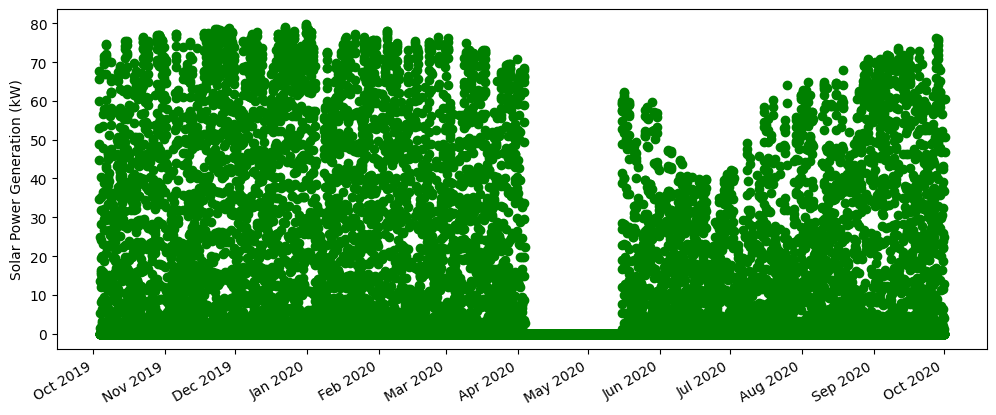

In [13]:
# Plot the data
plt.figure(figsize=(12, 5))
plt.scatter(solarData.start_timestamp, solarData.series_values, c='green')
# Format the x-axis to show all months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks for months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Month Year'
# Auto-format date labels for readability
plt.gcf().autofmt_xdate()
# Label the y-axis
plt.ylabel('Solar Power Generation (kW)')

The above visuals give a sense of the solar generation range and overall trend for the solar panel, but it is difficult to see what is happening at the 30-minute level we will build our forecasting and optimization solution around. The plot below shows solar genration for each 30-minute interval for two consecutive days. Change the date and time below to see how the solar output changes. 

Text(0, 0.5, 'Solar Power Generation (kW)')

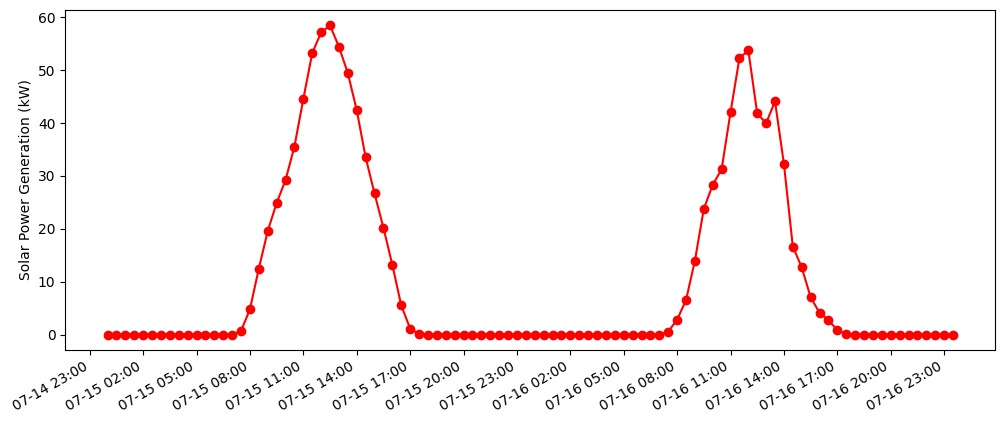

In [14]:
# Define the start and end dates for filtering
start_date = '2020-07-15 00:00:00'
end_date = '2020-07-16 23:59:00'
# Filter the data
filtered_data = solarData[(solarData.start_timestamp >= start_date) & (solarData.start_timestamp < end_date)]
# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(filtered_data.start_timestamp, filtered_data.series_values, '-o', c='red')
# Format the x-axis to show both date and hour at 3-hour intervals startig from start_date
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Major ticks for every 3 hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Format as 'Month-Day Hour:Minute'
# Auto-format date labels for better readability
plt.gcf().autofmt_xdate()
# Label the y-axis
plt.ylabel('Solar Power Generation (kW)')

Going back to the initial figures, we notice that there are some missing values in the data. Specifically, there is a range of missing zero values from the beginning of April 2020 to the middle of May 2020. In the following code, we will determine the date and hour range during which solar power generation was zero for several consecutive days.

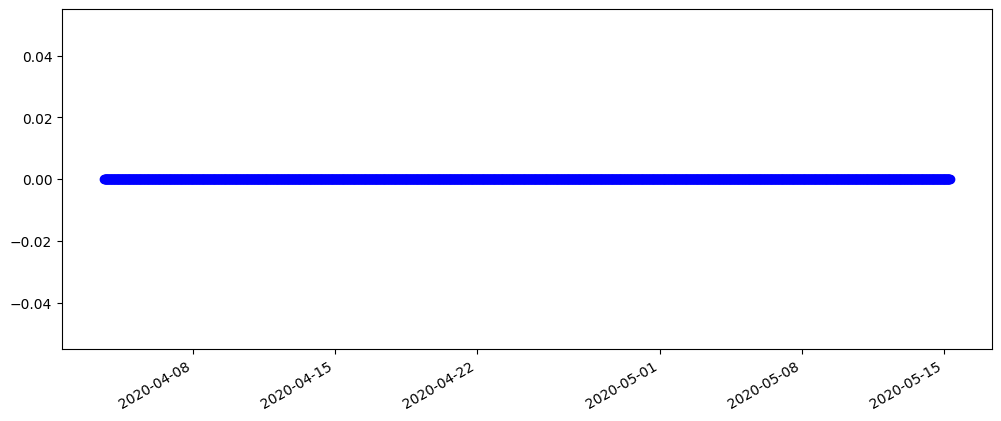

In [15]:
# Determine the date/hour range where the solar power generation is zero for sveral days in a row
# Find the consecutive zero values
zero_ranges = [] # List to store the zero ranges
zero_range = [] # List to store the current zero range
for i in range(len(solarData)): # Loop through the data
    if solarData.series_values[i] == 0: # If the value is zero
        zero_range.append(solarData.start_timestamp[i]) # Add the timestamp to the zero range
    else: # If the value is not zero
        if len(zero_range) > 0: # If there was a zero range
            zero_ranges.append(zero_range) # Add it to the zero ranges
            zero_range = [] # Reset the zero range
if len(zero_range) > 0: # If there was a zero range at the end
    zero_ranges.append(zero_range) # Add it to the zero ranges
# Find the longest zero range
longest_zero_range = max(zero_ranges, key=len) 
# Filter the data for the longest zero range and plot it (Just to be sure)
zeroSolarData = solarData[(solarData.start_timestamp >= longest_zero_range[0]) & (solarData.start_timestamp < longest_zero_range[-1])]
# Plot the data
plt.figure(figsize=(12,5))
plt.scatter(zeroSolarData.start_timestamp, zeroSolarData.series_values, c='blue')
plt.gcf().autofmt_xdate()


We will remove these points later on in the example as they do no fit with the general daily pattern we saw earlier. 

### Forecasting Solar Power Generation Using Prophet
We will now employ Facebook's Prophet, a robust time series forecasting library, to predict solar power generation for the upcoming week. Prophet is designed for ease of use and has consistently shown reliable performance in forecasting scenarios involving seasonality, trends, and irregularities, making it well-suited for this type of problem.

First, we will preprocess the training data to comply with Prophet's required format, which includes two columns: `ds` for timestamps and `y` for the corresponding values of solar power generation. Once the data is prepared, we will fit a Prophet model to the training dataset to capture patterns and trends in the historical solar power data.

Next, we will use the fitted model to forecast solar power output for the next seven days. The generated forecast will provide both point estimates and confidence intervals for solar generation at regular intervals.

Finally, we will refine the forecast by extracting the specific time range of interest, which spans from Monday, October 5th, 2020, through Saturday, October 10th, 2020. This cropped forecast will be used for further analysis and visualization to ensure alignment with our study objectives.

#### Preparing Solar Data and Forecasting Future Solar Power Generation Using Prophet

In [16]:
# Initialize an empty DataFrame to hold the reformatted data for Prophet
solarP = pd.DataFrame()
 
# Step 1: Prepare the data
# Assign the 'start_timestamp' column from solarData to the new column 'ds' in solarB
# 'ds' is the required datetime column name for Prophet
solarP['ds'] = solarData.start_timestamp

# Assign the 'series_values' column from solarData to the new column 'y' in solarB
# 'y' is the required target column name for Prophet and must contain numeric values
solarP['y'] = solarData.series_values
#print(f"Number of days after filtering: {solarP['ds'].dt.date.nunique()}")

# Filter the data to exclude entries that are present in zeroSolarData (removes unwanted data points)
solarP = solarP.loc[~solarP.index.isin(zeroSolarData.index)]
#print(f"Number of days after filtering: {solarP['ds'].dt.date.nunique()}")

# Step 2: Create and configure the Prophet model
# Initialize a Prophet model and specify custom changepoints for potential trend changes
# Changepoints are set at the start of specific months
modelP = Prophet(changepoints=[
    '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
    '2020-03-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'
])

# Add daily seasonality to the model
# Set the period to 1 day, Fourier order to 5 for seasonal complexity,
# prior_scale for regularization, and mode to 'multiplicative' for scaling effect
# The parmaters of the function add_seasonality are the following:
    # name: The name of the seasonality component
    # period: The period of the seasonality component in days
    # fourier_order: The number of Fourier components to use for the seasonality
    # prior_scale: The prior scale for the seasonality prior
    # mode: The seasonality mode ('additive' or 'multiplicative')
modelP.add_seasonality(name='daily', period=1, fourier_order=5, prior_scale=10, mode='multiplicative')

# Fit the Prophet model to the prepared data
modelP.fit(solarP)

# Step 3: Make future predictions
# Create a DataFrame with future timestamps for prediction
# The future DataFrame spans 452 half-hour intervals (equivalent to 226 hours, ~9.4 days)
futureP = modelP.make_future_dataframe(periods=452, freq='30min')

# Generate the forecast for the specified future periods
forecastP = modelP.predict(futureP)
print(forecastP)


21:49:16 - cmdstanpy - INFO - Chain [1] start processing
21:49:16 - cmdstanpy - INFO - Chain [1] done processing


                       ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2019-10-03 13:00:00  15.654696   36.403281   62.162964    15.654696   
1     2019-10-03 13:30:00  15.655597   35.867870   60.272287    15.655597   
2     2019-10-03 14:00:00  15.656499   32.432749   58.372463    15.656499   
3     2019-10-03 14:30:00  15.657400   29.832792   55.049328    15.657400   
4     2019-10-03 15:00:00  15.658302   24.165159   49.863865    15.658302   
...                   ...        ...         ...         ...          ...   
15913 2020-10-10 17:30:00  17.191040   -5.626623   20.922388    17.191040   
15914 2020-10-10 18:00:00  17.192005   -9.064755   16.426574    17.192005   
15915 2020-10-10 18:30:00  17.192970  -11.410996   15.071725    17.192970   
15916 2020-10-10 19:00:00  17.193936  -13.053738   12.884545    17.193936   
15917 2020-10-10 19:30:00  17.194901  -13.238801   12.040307    17.194901   

       trend_upper  additive_terms  additive_terms_lower  \
0        15.654

#### Evaluating and Visualizing Solar Power Forecast Accuracy

RMSE: 10.19419 MAE: 5.947753


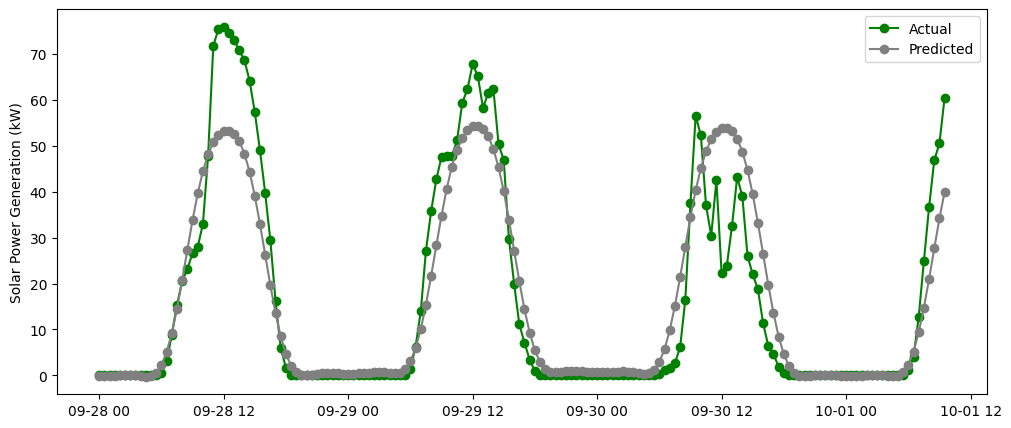

In [17]:

# Step 1: Merge actual and predicted data
# Combine the actual data (solarP) with the forecasted data (forecastP)
# Only keep the 'ds' (timestamps) and 'yhat' (predicted values) columns from forecastP
diff = solarP.merge(forecastP[['ds', 'yhat']])

# Step 2: Evaluate model performance
# Calculate Root Mean Square Error (RMSE) to measure the average deviation of predictions
rmse = np.sqrt(np.mean(np.square(diff.y - diff.yhat)))

# Calculate Mean Absolute Error (MAE) to measure the average magnitude of errors
mae = np.mean(np.abs(diff.y - diff.yhat))

# Print the performance metrics with six decimal places for precision
# RMSE should be as low as possible, while MAE should be close to zero
print(f"RMSE: {round(rmse, 6)} MAE: {round(mae, 6)}")

# Step 3: Visualize actual vs predicted solar power generation
plt.figure(figsize=(12, 5))

selected_date = '2020-09-28 00:00:00' # Specify the date to visualize
# Plot the actual solar power generation for timestamps on or after the selected date
plt.plot(
    diff.ds[diff.ds >= selected_date], 
    diff.y[diff.ds >= selected_date], 
    '-o', c='green', label='Actual'
)

# Plot the predicted solar power generation (yhat) for the same time range
plt.plot(
    diff.ds[diff.ds >= selected_date], 
    diff.yhat[diff.ds >= selected_date], 
    '-o', c='gray', label='Predicted'
)


# Label the y-axis to indicate the unit of measurement
plt.ylabel('Solar Power Generation (kW)')

# Add a legend to differentiate between actual and predicted values
plt.legend()

#### Forecasting Solar Data for October

In [18]:
# Step 1: Filter forecasted data for October
# Select forecasted values starting from '2020-10-05' to focus on the desired timeframe
forecastP_October = forecastP[(forecastP.ds >= '2020-10-05')]

# Set the 'ds' (timestamps) column as the index for easier time-based operations
forecastP_October = forecastP_October.set_index('ds')

# Step 2: Restrict the forecast data to daytime hours
# Create a copy of the October forecast data and filter it to include only values between 05:00 and 19:30
forecastP_October_Optimization = forecastP_October.copy().between_time('05:00:00', '19:30:00')

# Step 3: Adjust negative predictions to zero
# Replace any rows where the forecasted solar power generation ('yhat') is less than 0 with 0
# This ensures that the optimization model works with non-negative values
forecastP_October_Optimization.iloc[forecastP_October_Optimization.yhat < 0, :] = 0

# Step 4: Export the prepared data
# Save the optimized forecasted solar power generation values to a CSV file
# This file will be used as an input for the optimization model
forecastP_October_Optimization.to_csv('ml_pred_solar_values.csv', index=False)
